# **임대주택 단지 내 적정 주차수요 예측 대회**

In [1]:
PATH = r'C:\Users\Wyatt\wyatt37\data\parking'

In [2]:
import pandas as pd
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
from tabulate import tabulate

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

import warnings
warnings.filterwarnings("ignore")

In [3]:
from sklearn.model_selection import KFold

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LassoLars, HuberRegressor, LassoLarsCV

In [4]:
from pycaret.regression import *

In [5]:
age_gender = pd.read_csv(PATH + '\\new_age_gender_info.csv')
train = pd.read_csv(PATH + '\\new_train.csv')
test = pd.read_csv(PATH + '\\new_test.csv')
sub = pd.read_csv(PATH + '\\new_sample_submission.csv')

# PREPROCESSING

In [6]:
# 컬럼명이 너무 긴 지하철과 버스만 바꿔주겠습니다.
train.rename({'도보 10분거리 내 지하철역 수(환승노선 수 반영)': '지하철',
             '도보 10분거리 내 버스정류장 수': '버스'}, axis=1, inplace=True)
test.rename({'도보 10분거리 내 지하철역 수(환승노선 수 반영)': '지하철',
             '도보 10분거리 내 버스정류장 수': '버스'}, axis=1, inplace=True)

## FILLNA

### Subway

In [7]:
# train set에 지하철 정보가 없는 경남, 충남은 0으로 보간
train.loc[(train['지역'].isin(['경상남도', '충청남도'])) & (train['지하철'].isnull()), '지하철'] = 0

In [8]:
# LH청약센터에서 찾은 주소로 확인한 대전의 8개 단지는 지하철이 없음
# 0으로 채워줍시다.

(train.loc[(train['지역'] == '대전광역시') & (train['지하철'].isnull()) , '지하철']) = 0

In [9]:
# test set에 지하철 정보가 없는 충남은 0으로 보간
test.loc[(test['지역'].isin(['충청남도'])) & (test['지하철'].isnull()), '지하철'] = 0

In [10]:
# LH청약센터에서 찾은 주소로 확인한 대전의 2개 단지는 지하철이 없음
# 0으로 채워줍시다.

(test.loc[(test['지역'] == '대전광역시') & (test['지하철'].isnull()), '지하철']) = 0

### Bus

In [11]:
# 버스정류장 결측치는 train set에 1개 단지에 존재
# 해당 단지는 양산신도시LH아파트 5단지
# 동일 단지인 C2431에서 2로 되어 있음.

train.loc[train['버스'].isnull(), '버스'] = 2

### Rent

In [12]:
# test set 에 임대보증금과 임대료가 결측치인 1개 단지 존재
# 해당 단지는 대전둔산1단지주공아파트
# 공고문에 의거, 임대보증금과 임대료 아래와 같이 보간

test.loc[(test['임대건물구분'] != '상가') & (test['임대보증금'].isnull()), '임대보증금'] = [5787000, 5787000, 11574000]
test.loc[(test['임대건물구분'] != '상가') & (test['임대료'].isnull()), '임대료'] = [79980, 79980, 159960]

### Qualification

In [13]:
# C2411 아파트의 자격유형은 전부 A로 되어 있음.
# 동일하게 A로 보간

test.loc[(test['단지코드'] == 'C2411') & (test['자격유형'].isnull()), '자격유형'] = 'A'

In [14]:
# C2253 아파트의 자격유형은 전부 C로 되어 있음.
# 동일하게 C로 보간

test.loc[(test['단지코드'] == 'C2253') & (test['자격유형'].isnull()), '자격유형'] = 'C'

## REPLACING

https://www.dacon.io/competitions/official/235745/talkboard/403708?page=1&dtype=recent

### ※ 동일한 단지에 코드가 2개로 부여된 단지 코드 (3쌍) : ['C2085', 'C1397'], ['C2431', 'C1649'], ['C1036', 'C2675'] 
 - C2675 단지는 테스트셋, 나머지는 트레인셋 입니다.

In [15]:
# ['C2085', 'C1397'] 을 C1397로 합병
train.loc[train['단지코드'] == 'C2085', '단지코드'] = 'C1397'
train.loc[train['단지코드'] == 'C1397', '총세대수'] = (
    train.loc[train['단지코드'] == 'C1397'].groupby(['단지코드'])['전용면적별세대수'].sum()[0]
)
train.loc[train['단지코드'] == 'C1397', '공가수'] = 9

In [16]:
# ['C2431', 'C1649'] 을 C1649로 합병
train.loc[train['단지코드'] == 'C2431', '단지코드'] = 'C1649'
train.loc[train['단지코드'] == 'C1649', '총세대수'] = (
    train.loc[train['단지코드'] == 'C1649'].groupby(['단지코드'])['전용면적별세대수'].sum()[0]
)
train.loc[train['단지코드'] == 'C1649', '공가수'] = 31
train.loc[train['단지코드'] == 'C1649', '등록차량수'] = 1214

In [17]:
# ['C1036', 'C2675'] 은 train과 test로 나누어져 있으니 drop
train.drop(train.loc[train['단지코드'] == 'C1036'].index, axis=0, inplace=True)
test.drop(test.loc[test['단지코드'] == 'C2675'].index, axis=0, inplace=True)

### ※ 차이가 94~452세대인 10개 단지(크기순) : ['C1490', 'C2497', 'C2620', 'C1344', 'C1024', 'C2470', 'C1206', 'C1740', 'C2405', 'C1804’]

In [18]:
# 경북혁신도시천년나무3단지
test.loc[test['단지코드'] == 'C2497', '전용면적별세대수'] = [114, 60, 275, 39]

# 충무공동혁신도시LH아파트5단지
train.loc[train['단지코드'] == 'C2405', '전용면적별세대수'] = [100, 100, 400]
# 경북혁신LH천년나무2단지
train.loc[train['단지코드'] == 'C1740', '전용면적별세대수'] = [305, 126, 184, 168]
# LH강남아이파크
train.loc[train['단지코드'] == 'C1024', '전용면적별세대수'] = [195, 60, 15, 154, 99, 48, 42, 53, 29, 23]
# 서울서초A4BL
train.loc[train['단지코드'] == 'C1344', '전용면적별세대수'] = [106, 96, 41, 39, 42, 100]
# 진천군 연미로 131 천년나무7단지
train.loc[train['단지코드'] == 'C1490', '전용면적별세대수'] = [105, 84, 472, 88]
# 나주빛가람LH3단지
train.loc[train['단지코드'] == 'C2620', '전용면적별세대수'] = [60, 227, 316, 160, 266]
# 남양주별내A1-3블록
train.loc[train['단지코드'] == 'C1804', '전용면적별세대수'] = [76, 82, 279, 28]

In [19]:
# 남양주별내A1-3블록
train = train.append({'단지코드': 'C1804',
                      '총세대수': 478,
                      '임대건물구분': '아파트',
                      '지역': '경기도',
                      '공급유형': '공공임대(10년)',
                      '전용면적': 75.78,
                      '전용면적별세대수': 13,
                      '공가수': 3.0,
                      '자격유형': 'A',
                      '임대보증금': 78957000,
                      '임대료': 530130,
                      '지하철': 0.0,
                      '버스': 3.0,
                      '단지내주차면수': 629.0,
                      '등록차량수': 951.0}, ignore_index=True)
# 대전대신2구역2단지
train = train.append({'단지코드': 'C2470',
                      '총세대수': 636,
                      '임대건물구분': '아파트',
                      '지역': '대전광역시',
                      '공급유형': '공공분양',
                      '전용면적': 74.99,
                      '전용면적별세대수': 72,
                      '공가수': 1.0,
                      '자격유형': 'A',
                      '임대보증금': 225013300,
                      '지하철': 1.0,
                      '버스': 2.0,
                      '단지내주차면수': 772.0,
                      '등록차량수': 887.0}, ignore_index=True)
train = train.append({'단지코드': 'C2470',
                      '총세대수': 636,
                      '임대건물구분': '아파트',
                      '지역': '대전광역시',
                      '공급유형': '공공분양',
                      '전용면적': 74.95,
                      '전용면적별세대수': 66,
                      '공가수': 1.0,
                      '자격유형': 'A',
                      '임대보증금': 226278000,
                      '지하철': 1.0,
                      '버스': 2.0,
                      '단지내주차면수': 772.0,
                      '등록차량수': 887.0}, ignore_index=True)
train = train.append({'단지코드': 'C2470',
                      '총세대수': 636,
                      '임대건물구분': '아파트',
                      '지역': '대전광역시',
                      '공급유형': '공공분양',
                      '전용면적': 74.99,
                      '전용면적별세대수': 92,
                      '공가수': 1.0,
                      '자격유형': 'A',
                      '임대보증금': 230417000,
                      '지하철': 1.0,
                      '버스': 2.0,
                      '단지내주차면수': 772.0,
                      '등록차량수': 887.0}, ignore_index=True)
# 속초청초아파트
train = train.append({'단지코드': 'C1206',
                      '총세대수': 755,
                      '임대건물구분': '아파트',
                      '지역': '강원도',
                      '공급유형': '영구임대',
                      '전용면적': 41.85,
                      '전용면적별세대수': 177,
                      '공가수': 1.0,
                      '자격유형': 'C',
                      '지하철': 0.0,
                      '버스': 4.0,
                      '단지내주차면수': 88.0,
                      '등록차량수': 90.0}, ignore_index=True)
train = train.append({'단지코드': 'C1206',
                      '총세대수': 755,
                      '임대건물구분': '아파트',
                      '지역': '강원도',
                      '공급유형': '영구임대',
                      '전용면적': 51.66,
                      '전용면적별세대수': 90,
                      '공가수': 1.0,
                      '자격유형': 'C',
                      '지하철': 0.0,
                      '버스': 4.0,
                      '단지내주차면수': 88.0,
                      '등록차량수': 90.0}, ignore_index=True)

In [20]:
# train의 C1024는 다른 단지와 다르게 총세대수보다 전용면적별세대수합이 더 큽니다.
train.loc[train['단지코드'] == 'C1024', '총세대수'] = (
    train.loc[train['단지코드'] == 'C1024'].groupby(['단지코드'])['전용면적별세대수'].sum()[0]
)

### ※ 실수가 발생한 단지 코드 (9개 단지) : ['C2335', 'C1327', 'C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988']
 - C2335, C1327 단지는 테스트셋, 나머지는 트레인셋 입니다.

In [21]:
# train.loc[(train['단지코드'].isin(['C2335', 'C1327', 'C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988']))
#          & (train['임대건물구분'] == '아파트')]

In [22]:
# # 노이즈로 판결났으므로 부득이하게 레코드 드랍
#train.drop(train.loc[train['단지코드'].isin(['C2335', 'C1327', 'C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988'])].index, axis=0, inplace=True)
test.drop(test.loc[test['단지코드'].isin(['C2335', 'C1327'])].index, axis=0, inplace=True)

### UnitCount

In [23]:
train = pd.merge(train.loc[:, ~train.columns.isin(['총세대수'])],
                 train.groupby(['단지코드'])['전용면적별세대수'].sum().reset_index().rename({'전용면적별세대수':'총세대수'}, axis=1),
                 how='left', on='단지코드')

In [24]:
test = pd.merge(test.loc[:, ~test.columns.isin(['총세대수'])],
                test.groupby(['단지코드'])['전용면적별세대수'].sum().reset_index().rename({'전용면적별세대수':'총세대수'}, axis=1),
                how='left', on='단지코드')

### Qualification

'D' 는 상가에서 보여지는 자격유형입니다. 그러나 train, test 셋에 각각 존재합니다.

In [25]:
# train의 C1350의 D는 최빈값 A로 넣겠습니다.
train.loc[(train['자격유형'] == 'D') & (train['임대건물구분'] == '아파트'), '자격유형'] = (
    train.loc[(train['단지코드'] == 'C1350') & (~train['임대료'].isnull()), '자격유형'].mode()[0]
)

In [26]:
# test의 C1006의 D값은 최빈값인 C로 대체하겠습니다.
test.loc[(test['단지코드'] == 'C1006') & (test['임대건물구분'] == '아파트'), '자격유형'] = (
    test.loc[(test['단지코드'] == 'C1006') & (test['임대건물구분'] == '아파트'), '자격유형'].mode()[0]
)

### Shops

용이한 전처리를 위해 상가는 따로 뗴어두고 나중에 합칩니다.

In [27]:
train_shops = train.loc[train['임대건물구분'] == '상가'].groupby(['단지코드']).sum()[['전용면적별세대수', '전용면적']]
test_shops = test.loc[test['임대건물구분'] == '상가'].groupby(['단지코드']).sum()[['전용면적별세대수', '전용면적']]

In [28]:
train = train.loc[train['임대건물구분'] == '아파트']
test = test.loc[test['임대건물구분'] == '아파트']

### Deposit / Rent Preprocessing

임대료가 없는 단지를 비교하기 위해서 임대료를 만들어주겠습니다.

In [29]:
# '-' 값을 0으로 만들어줍니다.
train.loc[train['임대보증금'] == '-', '임대보증금'] = 0
test.loc[test['임대보증금'] == '-', '임대보증금'] = 0

train.loc[train['임대료'] == '-', '임대료'] = 0
test.loc[test['임대료'] == '-', '임대료'] = 0

In [30]:
# nan 값 때문에 object로 되어 있습니다. 일단 0으로 채워 줍니다.
train['임대보증금'] = train['임대보증금'].fillna(0)
test['임대보증금'] = test['임대보증금'].fillna(0)

train['임대료'] = train['임대료'].fillna(0)
test['임대료'] = test['임대료'].fillna(0)

In [31]:
# 계산을 위해서 int로 바꿔줍니다.
train['임대보증금'] = train['임대보증금'].astype(int)
test['임대보증금'] = test['임대보증금'].astype(int)

train['임대료'] = train['임대료'].astype(int)
test['임대료'] = test['임대료'].astype(int)

In [32]:
# 면적당으로 보증금과 임대료를 산출해서 역으로 채워넣겠습니다.
train['면적당보증금'] = train['임대보증금'] / train['전용면적']
train['면적당임대료'] = train['임대료'] / train['전용면적']

test['면적당보증금'] = test['임대보증금'] / test['전용면적']
test['면적당임대료'] = test['임대료'] / test['전용면적']

In [33]:
# 0 값을 다시 NULL 값으로 바꿉니다.
train.loc[(train['면적당보증금'] == 0), ['임대보증금', '면적당보증금']] = np.nan
train.loc[(train['면적당임대료'] == 0), ['임대료', '면적당임대료']] = np.nan

test.loc[(test['면적당보증금'] == 0), ['임대보증금', '면적당보증금']] = np.nan
test.loc[(test['면적당임대료'] == 0), ['임대료', '면적당임대료']] = np.nan

train에서 공공분양, 장기전세가 아니면서 보증금과 임대료가 비어있는 곳은 C1350, C1786, C2186, C1326, C1206 입니다.

In [34]:
# C1350은 공공분양이기 때문에 임대료가 없고 보증금이 매우 큽니다.
# 이 경우는 비슷한 공급유형의 면적당보증금을 가져오겠습니다.
# 임대료는 추후 작업하겠습니다.

# 같은 유형의 공공분양 단지의 면적당 보증금의 평균으로 채워줍니다.
train.loc[(train['단지코드'] == 'C1350') & (train['임대보증금'].isnull()), '면적당보증금'] = (
    train.loc[(train['공급유형'] == '공공분양') & (~train['임대보증금'].isnull()), '면적당보증금'].mean()
)

# 면적당보증금과 전용면적을 곱해서 임대보증금을 만들어줍니다.
train.loc[(train['단지코드'] == 'C1350') & (train['임대보증금'].isnull()), '임대보증금'] = (
    train.loc[(train['단지코드'] == 'C1350') & (train['임대보증금'].isnull()), '전용면적']
    * train.loc[(train['단지코드'] == 'C1350') & (train['임대보증금'].isnull()), '면적당보증금']
)

In [35]:
# C1786 은 행복주택, K 유형의 아파트입니다.
# 동일한 공급유형, 자격유형의 값을 가져오겠습니다.
train.loc[(train['단지코드'] == 'C1786') & (train['자격유형'] == 'K'), '면적당보증금'] = (
    train.loc[(train['공급유형'] == '행복주택') & (train['자격유형'] == 'K'), '면적당보증금'].mean()
)
train.loc[(train['단지코드'] == 'C1786') & (train['자격유형'] == 'K'), '면적당임대료'] = (
    train.loc[(train['공급유형'] == '행복주택') & (train['자격유형'] == 'K'), '면적당임대료'].mean()
)

# 면적당보증금과 전용면적을 곱해서 임대보증금을 만들어줍니다.
train.loc[(train['단지코드'] == 'C1786') & (train['자격유형'] == 'K'), '임대보증금'] = (
    train.loc[(train['단지코드'] == 'C1786') & (train['자격유형'] == 'K'), '전용면적']
    * train.loc[(train['단지코드'] == 'C1786') & (train['자격유형'] == 'K'), '면적당보증금']
)
train.loc[(train['단지코드'] == 'C1786') & (train['자격유형'] == 'K'), '임대료'] = (
    train.loc[(train['단지코드'] == 'C1786') & (train['자격유형'] == 'K'), '전용면적']
    * train.loc[(train['단지코드'] == 'C1786') & (train['자격유형'] == 'K'), '면적당임대료']
)

In [36]:
# C2186 단지는 같은 단지에 동일한 공급유형, 동일한 자격유형의 값이 있습니다.
# 해당 값으로 넣어주겠습니다.
train.loc[(train['단지코드'] == 'C2186') & (train['임대료'].isnull()), '면적당임대료'] = (
    train.loc[(train['단지코드'] == 'C2186') & (train['자격유형'] == 'H') & (~train['임대료'].isnull()), '면적당임대료'].mean()
)
train.loc[(train['단지코드'] == 'C2186') & (train['임대보증금'].isnull()), '면적당보증금'] = (
    train.loc[(train['단지코드'] == 'C2186') & (train['자격유형'] == 'H') & (~train['임대보증금'].isnull()), '면적당보증금'].mean()
)

# 면적당보증금과 전용면적을 곱해서 임대보증금을 만들어줍니다.
train.loc[(train['단지코드'] == 'C2186') & (train['임대료'].isnull()), '임대료'] = (
    train.loc[(train['단지코드'] == 'C2186') & (train['임대료'].isnull()), '전용면적']
    * train.loc[(train['단지코드'] == 'C2186') & (train['임대료'].isnull()), '면적당임대료']
)
train.loc[(train['단지코드'] == 'C2186') & (train['임대보증금'].isnull()), '임대보증금'] = (
    train.loc[(train['단지코드'] == 'C2186') & (train['임대보증금'].isnull()), '전용면적']
    * train.loc[(train['단지코드'] == 'C2186') & (train['임대보증금'].isnull()), '면적당보증금']
)

In [37]:
# C1326 단지는 동일 지역에 H국민임대 단지가 없습니다. 전국적으로 4000~6500원 선이니 평균으로 넣어주겠습니다.
train.loc[train['단지코드'] == 'C1326', '면적당보증금'] = (
    train.loc[(train['공급유형'] == '국민임대') & (train['자격유형'] == 'H'), '면적당보증금'].mean()
)
train.loc[train['단지코드'] == 'C1326', '면적당임대료'] = (
    train.loc[(train['공급유형'] == '국민임대') & (train['자격유형'] == 'H'), '면적당임대료'].mean()
)

# 면적당보증금과 전용면적을 곱해서 임대보증금을 만들어줍니다.
train.loc[train['단지코드'] == 'C1326', '임대보증금'] = (
    train.loc[train['단지코드'] == 'C1326', '면적당보증금']
    * train.loc[train['단지코드'] == 'C1326', '전용면적']
)
train.loc[train['단지코드'] == 'C1326', '임대료'] = (
    train.loc[train['단지코드'] == 'C1326', '면적당임대료']
    * train.loc[train['단지코드'] == 'C1326', '전용면적']
)

In [38]:
# C1206 단지는 동일 단지로 채워줍니다.
train.loc[(train['단지코드'] == 'C1206') & (train['임대보증금'].isnull()), '면적당보증금'] = (
    train.loc[(train['공급유형'] == '영구임대') & (~train['임대보증금'].isnull()), '면적당보증금'].mean()
)
train.loc[(train['단지코드'] == 'C1206') & (train['임대료'].isnull()), '면적당임대료'] = (
    train.loc[(train['공급유형'] == '영구임대') & (~train['임대료'].isnull()), '면적당임대료'].mean()
)

# 면적당보증금과 전용면적을 곱해서 임대보증금을 만들어줍니다.
train.loc[(train['단지코드'] == 'C1206') & (train['임대보증금'].isnull()), '임대보증금'] = (
    train.loc[(train['단지코드'] == 'C1206') & (train['임대보증금'].isnull()), '전용면적']
    * train.loc[(train['단지코드'] == 'C1206') & (train['임대보증금'].isnull()), '면적당보증금']
)
train.loc[(train['단지코드'] == 'C1206') & (train['임대료'].isnull()), '임대료'] = (
    train.loc[(train['단지코드'] == 'C1206') & (train['임대료'].isnull()), '전용면적']
    * train.loc[(train['단지코드'] == 'C1206') & (train['임대료'].isnull()), '면적당임대료']
)

test의 보증금과 임대료가 비어 있는 곳은 C1267, C2152 입니다.

In [39]:
# C1267 단지는 train의 동일공급유형, 동일자격유형, 거기에 경기도를 뺀 지역의 평균을 넣겠습니다.
test.loc[(test['단지코드'] == 'C1267') & (test['임대보증금'].isnull()), '면적당보증금'] = (
    train.loc[(train['공급유형'] == '행복주택') & (train['자격유형'] == 'L') & (train['지역'] != '경기도'), '면적당보증금'].mean()
)
test.loc[(test['단지코드'] == 'C1267') & (test['임대료'].isnull()), '면적당임대료'] = (
    train.loc[(train['공급유형'] == '행복주택') & (train['자격유형'] == 'L') & (train['지역'] != '경기도'), '면적당임대료'].mean()
)

# 면적당보증금과 전용면적을 곱해서 임대보증금을 만들어줍니다.
test.loc[(test['단지코드'] == 'C1267') & (test['임대보증금'].isnull()), '임대보증금'] = (
    test.loc[(test['단지코드'] == 'C1267') & (test['임대보증금'].isnull()), '전용면적']
    * test.loc[(test['단지코드'] == 'C1267') & (test['임대보증금'].isnull()), '면적당보증금']
)
test.loc[(test['단지코드'] == 'C1267') & (test['임대료'].isnull()), '임대료'] = (
    test.loc[(test['단지코드'] == 'C1267') & (test['임대료'].isnull()), '전용면적']
    * test.loc[(test['단지코드'] == 'C1267') & (test['임대료'].isnull()), '면적당임대료']
)

In [40]:
# C2152 단지는 train의 동일 공급유형, 자격유형의 전국 평균 값으로 넣겠습니다.
test.loc[test['단지코드'] == 'C2152', '면적당보증금'] = (
    train.loc[(train['공급유형'] == '영구임대') & (train['자격유형'] == 'C'), '면적당보증금'].mean()
)
test.loc[test['단지코드'] == 'C2152', '면적당임대료'] = (
    train.loc[(train['공급유형'] == '영구임대') & (train['자격유형'] == 'C'), '면적당임대료'].mean()
)

# 면적당보증금과 전용면적을 곱해서 임대보증금을 만들어줍니다.
test.loc[test['단지코드'] == 'C2152', '임대보증금'] = (
    test.loc[test['단지코드'] == 'C2152', '전용면적']
    * test.loc[test['단지코드'] == 'C2152', '면적당보증금']
)
test.loc[test['단지코드'] == 'C2152', '임대료'] = (
    test.loc[test['단지코드'] == 'C2152', '전용면적']
    * test.loc[test['단지코드'] == 'C2152', '면적당임대료']
)

장기전세와 공공분양 ['C1397', 'C1039', 'C1350', 'C2470', 'C1206']

In [41]:
# 결측치를 0으로 채워줍니다.
train['임대료'] = train['임대료'].fillna(0)
test['임대료'] = test['임대료'].fillna(0)

In [42]:
# 결측치를 0으로 채워줍니다.
train['면적당임대료'] = train['면적당임대료'].fillna(0)
test['면적당임대료'] = test['면적당임대료'].fillna(0)

In [43]:
# 환산보증금은 임대료의 354배와 보증금을 합친 값으로 정했습니다.
train['환산보증금'] = train['임대료'] * 354 + train['임대보증금']
test['환산보증금'] = test['임대료'] * 354 + test['임대보증금']

In [44]:
# 전용면적으로 나누어서 면적당환산보증급을 만들어줍니다.
train['면적당환산보증금'] = train['환산보증금'] / train['전용면적']
test['면적당환산보증금'] = test['환산보증금'] / test['전용면적']

In [45]:
# 전용면적과 전용면적별세대수를 곱해서 아파트 단지의 건축연면적을 뽑습니다.
train['건축연면적'] = train['전용면적'] * train['전용면적별세대수']
test['건축연면적'] = test['전용면적'] * test['전용면적별세대수']

In [46]:
# 전용면적별세대수와 환산보증금을 곱해서 아파트 단지의 총 환산보증금을 뽑습니다.
train['세대수X환산보증금'] = train['전용면적별세대수'] * train['환산보증금']
test['세대수X환산보증금'] = test['전용면적별세대수'] * test['환산보증금']

In [48]:
# 전용면적의 크기에 따른 방의 개수를 입력해줍니다.
# 기준은 통상적인 전용면적별 방의 개수로 했습니다.
train.loc[train['전용면적'] < 35, '방개수'] = '1룸'
train.loc[train['전용면적'] >= 35, '방개수'] = '2룸'
train.loc[train['전용면적'] >= 45, '방개수'] = '3룸'
train.loc[train['전용면적'] >= 56, '방개수'] = '4룸'
train.loc[train['전용면적'] >= 77, '방개수'] = '5룸'

test.loc[test['전용면적'] < 35, '방개수'] = '1룸'
test.loc[test['전용면적'] >= 35, '방개수'] = '2룸'
test.loc[test['전용면적'] >= 45, '방개수'] = '3룸'
test.loc[test['전용면적'] >= 56, '방개수'] = '4룸'
test.loc[test['전용면적'] >= 77, '방개수'] = '5룸'

In [49]:
# 전용면적의 크기에 따른 아파트 크기를 나눕니다.
# 통상적인 기준으로 정했습니다.

train.loc[train['전용면적'] < 40, '전용면적구분'] = '소형'
train.loc[train['전용면적'] >= 40, '전용면적구분'] = '중형'
train.loc[train['전용면적'] >= 80, '전용면적구분'] = '대형'

test.loc[test['전용면적'] < 40, '전용면적구분'] = '소형'
test.loc[test['전용면적'] >= 40, '전용면적구분'] = '중형'
test.loc[test['전용면적'] >= 80, '전용면적구분'] = '대형'

In [50]:
# 주어진 주차면수로 총세대수를 나눈 값을 넣어줍니다.
train['총세대수/주차면수'] = train['총세대수'] / train['단지내주차면수']
test['총세대수/주차면수'] = test['총세대수'] / test['단지내주차면수']

In [51]:
for x in list(train.공급유형.unique()):
    print(x, train.loc[train['공급유형'] == x]['자격유형'].unique())

국민임대 ['A' 'B' 'E' 'G' 'H']
공공임대(50년) ['A']
영구임대 ['C' 'E' 'F' 'I' 'A']
공공임대(10년) ['A']
공공임대(분납) ['A']
장기전세 ['A']
공공분양 ['A']
행복주택 ['J' 'K' 'L' 'M' 'N' 'O']
공공임대(5년) ['A']


In [52]:
# 특정 공급유형에만 존재하는 자격유형을 묶어줍니다.

train.loc[train['자격유형'].isin(['J', 'L', 'K', 'N', 'M', 'O']), '자격유형'] = '행복주택_공급대상'
test.loc[test['자격유형'].isin(['J', 'L', 'K', 'N', 'M', 'O']), '자격유형'] = '행복주택_공급대상'

train.loc[train['자격유형'].isin(['H', 'B', 'E', 'G']), '자격유형'] = '국민임대_공급대상'
test.loc[test['자격유형'].isin(['H', 'B', 'E', 'G']), '자격유형'] = '국민임대_공급대상'

train.loc[train['자격유형'].isin(['C', 'I', 'F']), '자격유형'] = '영구임대_공급대상'
test.loc[test['자격유형'].isin(['C', 'I', 'F']), '자격유형'] = '영구임대_공급대상'

# Modeling

In [53]:
train.head()

,단지코드,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철,버스,단지내주차면수,등록차량수,총세대수,면적당보증금,면적당임대료,환산보증금,면적당환산보증금,건축연면적,세대수X환산보증금,방개수,전용면적구분,총세대수/주차면수
0,C2483,아파트,경상북도,국민임대,39.72,134,38.0,A,15667000.0,103680.0,0.0,3.0,1425.0,1015.0,900,394436.052367,2610.271903,52369720.0,1.318472e+06,5322.48,7.017542e+09,2룸,소형,0.631579
1,C2483,아파트,경상북도,국민임대,39.72,15,38.0,A,15667000.0,103680.0,0.0,3.0,1425.0,1015.0,900,394436.052367,2610.271903,52369720.0,1.318472e+06,595.80,7.855458e+08,2룸,소형,0.631579
2,C2483,아파트,경상북도,국민임대,51.93,385,38.0,A,27304000.0,184330.0,0.0,3.0,1425.0,1015.0,900,525784.710187,3549.585981,92556820.0,1.782338e+06,19993.05,3.563438e+10,3룸,중형,0.631579
3,C2483,아파트,경상북도,국민임대,51.93,15,38.0,A,27304000.0,184330.0,0.0,3.0,1425.0,1015.0,900,525784.710187,3549.585981,92556820.0,1.782338e+06,778.95,1.388352e+09,3룸,중형,0.631579
4,C2483,아파트,경상북도,국민임대,51.93,41,38.0,A,27304000.0,184330.0,0.0,3.0,1425.0,1015.0,900,525784.710187,3549.585981,92556820.0,1.782338e+06,2129.13,3.794830e+09,3룸,중형,0.631579


In [54]:
# 공급유형 unstack
temp = train.groupby(['단지코드', '공급유형'])['전용면적별세대수'].sum().unstack().fillna(0)
train = pd.merge(train.loc[:, ~train.columns.isin(['공급유형'])], temp, on='단지코드')
temp = test.groupby(['단지코드', '공급유형'])['전용면적별세대수'].sum().unstack().fillna(0)
test = pd.merge(test.loc[:, ~test.columns.isin(['공급유형'])], temp, on='단지코드')

In [55]:
# 자격유형 unstack
temp = train.groupby(['단지코드', '자격유형'])['전용면적별세대수'].sum().unstack().fillna(0)
train = pd.merge(train.loc[:, ~train.columns.isin(['자격유형'])], temp, on='단지코드')
temp = test.groupby(['단지코드', '자격유형'])['전용면적별세대수'].sum().unstack().fillna(0)
test = pd.merge(test.loc[:, ~test.columns.isin(['자격유형'])], temp, on='단지코드')

In [56]:
# 면적당환산보증금세대수 합계로 산출
temp = train.groupby(['단지코드'])['세대수X환산보증금'].sum().reset_index()
train = pd.merge(train.loc[:, ~train.columns.isin(['세대수X환산보증금'])], temp, on='단지코드')
temp = test.groupby(['단지코드'])['세대수X환산보증금'].sum().reset_index()
test = pd.merge(test.loc[:, ~test.columns.isin(['세대수X환산보증금'])], temp, on='단지코드')

In [57]:
# 단지평균면적당환산보증금 산출
temp = train.groupby(['단지코드'])['면적당환산보증금'].mean().reset_index()
train = pd.merge(train.loc[:, ~train.columns.isin(['면적당환산보증금'])], temp, on='단지코드')
temp = test.groupby(['단지코드'])['면적당환산보증금'].mean().reset_index()
test = pd.merge(test.loc[:, ~test.columns.isin(['면적당환산보증금'])], temp, on='단지코드')

In [58]:
# 방개수 unstack
temp = train.groupby(['단지코드', '방개수'])['전용면적별세대수'].sum().unstack().fillna(0)
train = pd.merge(train.loc[:, ~train.columns.isin(['방개수'])], temp, on='단지코드')
temp = test.groupby(['단지코드', '방개수'])['전용면적별세대수'].sum().unstack().fillna(0)
test = pd.merge(test.loc[:, ~test.columns.isin(['방개수'])], temp, on='단지코드')

In [59]:
# 전용면적구분 unstack
temp = train.groupby(['단지코드', '전용면적구분'])['전용면적별세대수'].sum().unstack().fillna(0)
train = pd.merge(train.loc[:, ~train.columns.isin(['전용면적구분'])], temp, on='단지코드')
temp = test.groupby(['단지코드', '전용면적구분'])['전용면적별세대수'].sum().unstack().fillna(0)
test = pd.merge(test.loc[:, ~test.columns.isin(['전용면적구분'])], temp, on='단지코드')

In [60]:
# 건축연면적 합계로 산출
temp = train.groupby(['단지코드'])['건축연면적'].sum().reset_index()
train = pd.merge(train.loc[:, ~train.columns.isin(['건축연면적'])], temp, on='단지코드')
temp = test.groupby(['단지코드'])['건축연면적'].sum().reset_index()
test = pd.merge(test.loc[:, ~test.columns.isin(['건축연면적'])], temp, on='단지코드')

In [61]:
# 실거주세대 대비 차량수의 지역 평균으로 오름차순 정렬
# Order를 주었습니다.
region_dict = {'서울특별시': 0,
               '경기도':1,
               '세종특별자치시':2,
               '경상북도':3,
               '대구광역시':4,
               '광주광역시':5,
               '충청북도':6,
               '전라남도':7,
               '전라북도':8,
               '강원도':9,
               '경상남도':10,
               '울산광역시':11,
               '제주특별자치도':12,
               '대전광역시':13,
               '충청남도':14,
               '부산광역시':15}

train['지역'] = train['지역'].map(region_dict)
test['지역'] = test['지역'].map(region_dict)

In [62]:
# 전처리가 끝나서 필요없는 변수 삭제
train.drop(['임대건물구분', '전용면적', '전용면적별세대수', '임대보증금',
            '임대료', '환산보증금', '면적당보증금', '면적당임대료'], axis=1, inplace=True)
test.drop(['임대건물구분', '전용면적', '전용면적별세대수', '임대보증금',
           '임대료', '환산보증금', '면적당보증금', '면적당임대료'], axis=1, inplace=True)

In [63]:
# 단지고유의 레코드만 남겨줍니다.
train = train.drop_duplicates().reset_index(drop=True)
test = test.drop_duplicates().reset_index(drop=True)

In [64]:
train.shape, test.shape

((420, 33), (147, 29))

In [70]:
# 일전에 떼어 놓았던 상가 컬럼 두개를 합쳐줍니다.
train = pd.merge(train, train_shops.rename({'전용면적별세대수':'상가세대수', '전용면적':'상가면적합'}, axis=1).reset_index(),
                 how='left', on='단지코드')
test = pd.merge(test, test_shops.rename({'전용면적별세대수':'상가세대수', '전용면적':'상가면적합'}, axis=1).reset_index(),
                how='left', on='단지코드')

In [65]:
set(train.columns).difference(test.columns)

{'공공분양', '공공임대(5년)', '등록차량수', '장기전세'}

In [66]:
# 테스트 셋에는 없는 컬럼을 드랍해줍니다.
train.drop(['장기전세', '공공분양', '공공임대(5년)'], axis=1, inplace=True)

In [71]:
train.head()

,단지코드,지역,공가수,지하철,버스,단지내주차면수,등록차량수,총세대수,총세대수/주차면수,공공임대(10년),공공임대(50년),공공임대(분납),국민임대,영구임대,행복주택,A,국민임대_공급대상,영구임대_공급대상,행복주택_공급대상,세대수X환산보증금,면적당환산보증금,1룸,2룸,3룸,4룸,5룸,대형,소형,중형,건축연면적,상가세대수,상가면적합
0,C2483,3,38.0,0.0,3.0,1425.0,1015.0,900,0.631579,0.0,0.0,0.0,900.0,0.0,0.0,900.0,0.0,0.0,0.0,7.848731e+10,1.665119e+06,0.0,149.0,665.0,86.0,0.0,0.0,149.0,751.0,45605.89,NaN,NaN
1,C2515,10,17.0,0.0,3.0,624.0,205.0,545,0.873397,0.0,0.0,0.0,545.0,0.0,0.0,545.0,0.0,0.0,0.0,3.069148e+10,1.461542e+06,276.0,80.0,189.0,0.0,0.0,0.0,356.0,189.0,21941.82,NaN,NaN
2,C1407,13,13.0,1.0,1.0,1285.0,1064.0,1216,0.946304,0.0,0.0,0.0,1216.0,0.0,0.0,1216.0,0.0,0.0,0.0,1.072339e+11,2.173057e+06,390.0,362.0,464.0,0.0,0.0,0.0,390.0,826.0,49159.08,NaN,NaN
3,C1945,1,6.0,1.0,3.0,734.0,730.0,755,1.028610,0.0,0.0,0.0,755.0,0.0,0.0,0.0,755.0,0.0,0.0,6.703930e+10,1.748453e+06,0.0,240.0,303.0,212.0,0.0,0.0,240.0,515.0,37962.15,NaN,NaN
4,C1470,8,14.0,0.0,2.0,645.0,553.0,696,1.079070,0.0,0.0,0.0,696.0,0.0,0.0,696.0,0.0,0.0,0.0,4.440690e+10,1.390810e+06,0.0,254.0,442.0,0.0,0.0,0.0,254.0,442.0,31250.88,NaN,NaN


In [72]:
test.head()

,단지코드,지역,공가수,지하철,버스,단지내주차면수,총세대수,총세대수/주차면수,공공임대(10년),공공임대(50년),공공임대(분납),국민임대,영구임대,행복주택,A,국민임대_공급대상,영구임대_공급대상,행복주택_공급대상,세대수X환산보증금,면적당환산보증금,1룸,2룸,3룸,4룸,5룸,대형,소형,중형,건축연면적,상가세대수,상가면적합
0,C1072,1,14.0,0.0,2.0,683.0,754,1.103953,0.0,0.0,0.0,754.0,0.0,0.0,30.0,724.0,0.0,0.0,9.892643e+10,2.713866e+06,0.0,116.0,638.0,0.0,0.0,0.0,116.0,638.0,36394.95,NaN,NaN
1,C1128,1,9.0,0.0,3.0,1216.0,1354,1.113487,0.0,0.0,0.0,1354.0,0.0,0.0,222.0,1132.0,0.0,0.0,1.680103e+11,2.594390e+06,0.0,420.0,934.0,0.0,0.0,0.0,420.0,934.0,63429.68,NaN,NaN
2,C1456,15,18.0,0.0,16.0,547.0,619,1.131627,0.0,0.0,0.0,619.0,0.0,0.0,619.0,0.0,0.0,0.0,7.042407e+10,2.488889e+06,82.0,165.0,328.0,44.0,0.0,0.0,247.0,372.0,27958.80,NaN,NaN
3,C1840,8,7.0,0.0,3.0,543.0,593,1.092081,0.0,0.0,0.0,593.0,0.0,0.0,593.0,0.0,0.0,0.0,3.596387e+10,1.397721e+06,0.0,335.0,258.0,0.0,0.0,0.0,335.0,258.0,25778.67,NaN,NaN
4,C1332,1,11.0,0.0,2.0,1112.0,1297,1.166367,0.0,0.0,0.0,1297.0,0.0,0.0,0.0,1297.0,0.0,0.0,1.824962e+11,3.090162e+06,0.0,425.0,872.0,0.0,0.0,0.0,425.0,872.0,59456.73,NaN,NaN


In [73]:
train.shape, test.shape

((420, 32), (147, 31))

In [74]:
train = train.fillna(0)
test = test.fillna(0)

In [75]:
x_train = train.loc[:, ~train.columns.isin(['단지코드', '등록차량수'])]
y_train = train['등록차량수']
x_test = test.loc[:, ~test.columns.isin(['단지코드'])]
x_code = test['단지코드']

In [76]:
x_train.shape, y_train.shape, x_test.shape, x_code.shape

((420, 30), (420,), (147, 30), (147,))

In [77]:
# 다양한 알고리즘과 하이퍼파라미터 튜닝을 거쳤지만, 랜포가 가장 높은 성능
rf = RandomForestRegressor(random_state=42, oob_score=True, criterion='mse', n_estimators=200)
rf.fit(x_train, y_train)
pred = rf.predict(x_test)

In [78]:
rf.oob_score_

0.7793952713748383

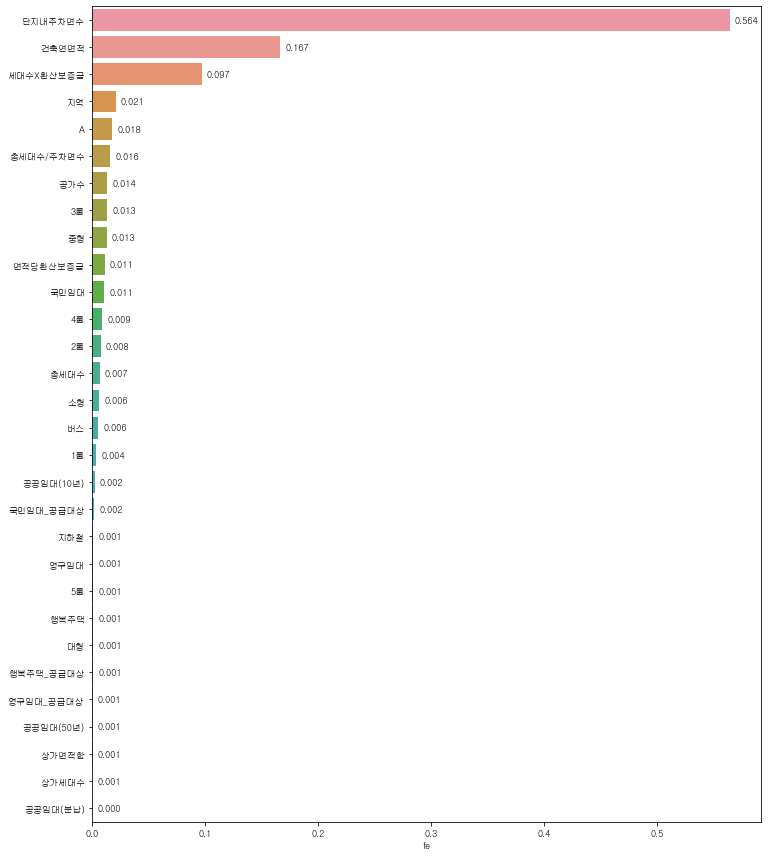

In [79]:
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams["font.size"] = "9"

fe_avg = pd.DataFrame(rf.feature_importances_,
                      index=x_train.columns, columns=['fe']).sort_values(by=['fe'], ascending=False)

plt.figure(figsize=(12, 15))
plots = sns.barplot(fe_avg.fe, y=fe_avg.index)

# Annotate every single Bar with its value, based on it's width           
for bar in plots.patches:
    width = bar.get_width()
    plt.text(0.015+ bar.get_width(),
             bar.get_y() + 0.5 * bar.get_height(),
             '{:.3f}'.format(width),
             ha='center', va='center')

plt.show()

In [80]:
pred = pred.round()

In [81]:
sub = pd.merge(sub, pd.DataFrame(pred, index=x_code, columns=['pred']).reset_index(),
               how='left', left_on='code', right_on='단지코드').fillna(0)[['code', 'pred']]

In [82]:
sub.rename({'pred':'num'}, axis=1, inplace=True)

In [88]:
sub.head()

,code,num
0,C1072,800.0
1,C1128,1169.0
2,C1456,511.0
3,C1840,534.0
4,C1332,1254.0


- Public Score: 98.28571
- Private Score: 110.81632

- Public Rank: 120th
- Private Rank: 83th